### Install và import thư viện 

In [1]:
!pip install nltk
!pip install pyspellchecker


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import re 
import html
import string

import nltk
from nltk.tokenize import TweetTokenizer, RegexpTokenizer

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
from spellchecker import SpellChecker

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from lightgbm import LGBMClassifier


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Đọc lại dữ liệu (Phần này ở tiền xử lý và khám phá không tác động nên khi merge file không cần cũng được)

In [3]:
train_df=pd.read_csv("datasets/train.csv")

In [4]:
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [5]:
test_df=pd.read_csv("datasets/test.csv")

In [6]:
tweet_df=pd.concat([train_df,test_df])

In [7]:
tweet_df.shape

(10876, 5)

In [8]:
tweet_df.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1.0
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1.0
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1.0
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1.0
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1.0


Copy DataFrame gốc

In [9]:
train_lightGBM_df=train_df.__deepcopy__()
test_lightGBM_df=test_df.__deepcopy__()

- Nhận xét: 
    - Trong thuộc tính `text` của DataFrame ta thấy xuất hiện các thẻ của html nhưng chưa định dạng về đúng, ví dụ: &amp ~ &, &lt ~ <, &gt ~ >

Chuẩn hóa lại `text`

In [10]:
def decode_html(text):
    return html.unescape(text)

In [11]:
train_lightGBM_df.text=train_lightGBM_df.text.apply(decode_html)
test_lightGBM_df.text=test_lightGBM_df.text.apply(decode_html)

Khởi tạo các list và dictionary để tiện cho việc xử dụng

In [12]:
# Emoticon thường sử dụng
emoticons=['-.-', '-_-', '8)', '8-)', '8-D', '8D', ':!]', ':#', ':$', ':&', ':(', ':)', ':*', ':+', ':-(', ':-)', ':-*', ':-/', ':->', ':-?', ':-D', ':-O', ':-P', ':-]', ':-|', ':-}', ':/', ':3', ':>', ':@', ':D', ':O', ':P', ':]', ':^)', ':c)', ':o)', ':s', ':v', ':|', ':}', ';)', ';-)', '>:(', '<3', '=)', '=3', '=D', '=]', 'B^D', 'C:', 'O.o', '^_^', 'c:', 'o.o', "):", '8:' ,']:']

# Các ký tự viết tắt
truncated_words_dict={"lol" : "laughing out loud","brb" : "be right back","btw" : "by the way","omg" : "oh my god","bff" : "best friend forever","imo" : "in my opinion","irl" : "in real life","lmk" : "let me know","np" : "no problem","nvm" : "nevermind","pls" : "please","thx" : "thanks","u" : "you","ur" : "your","wtf" : "what the fuck","yolo" : "you only live once","tbh" : "to be honest","smh" : "shaking my head","rn" : "right now","fyi" : "for your information","afk" : "away from keyboard","bae" : "before anyone else","bc" : "because","cuz" : "because","def" : "definitely","dunno" : "do not know","gonna" : "going to","gr8" : "great","idk" : "I do not know","ikr" : "I know, right?","jk" : "just kidding","k" : "okay","obv" : "obviously","probs" : "probably","rly" : "really","sry" : "sorry","ttyl" : "talk to you later","yw" : "you are welcome","ig" : "Instagram",}

# Stop words
stop_words = stopwords.words('english')
addstops = ["among", "onto", "shall", "thrice", "thus", "twice", "unto", "us", "would"]
allstops = set(stop_words + addstops)



Thực hiện viết và gọi hàm cleanData

In [13]:
tokenizer_tweet=TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
regexp= RegexpTokenizer(r'\w+')
lemmatizer=WordNetLemmatizer()

truncated_words_keys=list(truncated_words_dict)
def cleanData(text):
  scripts_remove=["http\S+",        # Xóa địa chỉ web
                  "<.*?>",           # Xóa các tag
                  "- Full.*",       # Các nội dung văn bản có xuất hiện ký tự - Full cho đến hết văn bản là nội dung KHÔNG CẦN THIẾT
                  "[^\x00-\x7F]_?", # Ký tự không thể decode về utf-8
                  "@\w+",           # Xóa các mention
                  "#\w+",           # Xóa các topic
                  "\t",             # Xóa tab
                  "\n"]             # Xóa xuống dòng

  # Xóa ký tự RT ở đầu văn bản
  text = re.sub(r'^RT\s*', ' ', text)

  # Xóa ký tự RT ở giữa văn bản
  text = re.sub(r'\bRT\b', '', text)

  # Thực hiện các thao tác trong scripts_remove
  for script in scripts_remove:
    text = re.sub(script, "", text)

  #  Xóa các khoảng trắng bị thừa
  text = re.sub("\s+", " ", text)
  
  # Loại bỏ ký tự trắng bị thừa ở trước và sau
  text = text.strip()

  # tokenize tweets
  tweet_tokens=tokenizer_tweet.tokenize(text)

  # Thay thế các  các từ viết tắt
  truncated_words=[]
  for word in tweet_tokens:
      if word in truncated_words_keys:
        truncated_words = truncated_words + truncated_words_dict[word].split()
      else:
        truncated_words = truncated_words + word.split()
  text_converted = " ".join(truncated_words)

  # Xóa stop words và các dấu nối câu
  tweet_tokens=tokenizer_tweet.tokenize(text_converted)
  text_clean_stop_words=[]
  for word in tweet_tokens:
    if (word not in allstops) and (word not in string.punctuation) and (word not in emoticons):
        text_clean_stop_words.append(word)
  return text_clean_stop_words

In [14]:
train_lightGBM_df["text_tokens"]=train_lightGBM_df.text.apply(cleanData)
test_lightGBM_df["text_tokens"]=test_lightGBM_df.text.apply(cleanData)
# tweet_df["tweet_tokens"]=tweet_df.text.apply(cleanData)

In [15]:
train_lightGBM_df

,id,keyword,location,text,target,text_tokens
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,"[deeds, reason, may, allah, forgive]"
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,"[residents, asked, shelter, place, notified, o..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"[13,000, people, receive, evacuation, orders, ..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[got, sent, photo, ruby, smoke, pours, school]"
...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,"[two, giant, cranes, holding, bridge, collapse..."
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,"[control, wild, fires, california, even, north..."
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,"[m1, 94, 01:04, utc, 5km, volcano, hawaii]"
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,"[police, investigating, e-bike, collided, car,..."


Nối các token lại để tạo thành câu/đoạn văn

In [16]:
def remove_punctuation(text):
    text = " ".join([char for char in text if char not in string.punctuation])
    return text

In [17]:
train_lightGBM_df["text_clean"]=train_lightGBM_df.text_tokens.apply(remove_punctuation)
test_lightGBM_df["text_clean"]=test_lightGBM_df.text_tokens.apply(remove_punctuation)
# tweet_df["Tweet"]=tweet_df.tweet_tokens.apply(remove_punctuation)

In [18]:
train_lightGBM_df

,id,keyword,location,text,target,text_tokens,text_clean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,"[deeds, reason, may, allah, forgive]",deeds reason may allah forgive
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,"[residents, asked, shelter, place, notified, o...",residents asked shelter place notified officer...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"[13,000, people, receive, evacuation, orders, ...","13,000 people receive evacuation orders califo..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[got, sent, photo, ruby, smoke, pours, school]",got sent photo ruby smoke pours school
...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,"[two, giant, cranes, holding, bridge, collapse...",two giant cranes holding bridge collapse nearb...
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,"[control, wild, fires, california, even, north...",control wild fires california even northern pa...
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,"[m1, 94, 01:04, utc, 5km, volcano, hawaii]",m1 94 01:04 utc 5km volcano hawaii
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,"[police, investigating, e-bike, collided, car,...",police investigating e-bike collided car littl...


Sửa chính tả cho các từ bị lỗi:
- Nhận xét: Chưa được tối ưu và chính xác. 
    - Số lượng nhiều.
    - Trong 1 từ  bị thiếu hoặc dư nhiều chữ

$ \implies$  Làm cho việc xác định, chỉnh sửa tốn thời gian, sẽ có hiện tượng tìm nhầm từ khác với nội dung ban đầu của người viết.

In [19]:
spell = SpellChecker(language="en")
def correct_spellings(text):
    words_list=tokenizer_tweet.tokenize(text)
    corrected_text = []
    for word in words_list:
        if word in spell.unknown(words_list):
            word_corrected=spell.correction(word)
            corrected_text.append(word_corrected if word_corrected is not None else '')
        else:
            corrected_text.append(word)
    text_corrected = " ".join(corrected_text)
    return text_corrected

Thực hiện kiểm tra chính tả các từ trong câu:

*Cell dưới đã được chạy trong lần đầu tiên và lưu kết quả vào file `train_corrected_text` và `test_corrected_text` để tiết kiệm thời gian*

In [20]:
print(train_lightGBM_df.text_clean.iloc[:50].apply(correct_spellings))
print(test_lightGBM_df.text_clean.iloc[:50].apply(correct_spellings))

# train_lightGBM_df["Tweet"]=train_lightGBM_df.text_clean.apply(correct_spellings)
# test_lightGBM_df["Tweet"]=test_lightGBM_df.text_clean.apply(correct_spellings)

# train_lightGBM_df.to_csv("train_corrected_text.csv",index=False)
# test_lightGBM_df.to_csv("test_corrected_text.csv",index=False)

0                        deeds reason may allah forgive
1                  forest fire near la range ask canada
2     residents asked shelter place notified officer...
3           people receive evacuation orders california
4                got sent photo ruby smoke pours school
5     update california why 20 closed directions due...
6     heavy rain causes flash flooding streets manit...
7                          i'm top hill see fire woods 
8     there's emergency evacuation happening buildin...
9                       i'm afraid tornado coming area 
10                      three people died heat wave far
11    haha south tampa getting flooded hah wait seco...
12                           18 19 days i've lost count
13                               ago mandar arrived ago
14                 damage school bus 80 multi car crash
15                                           what's man
16                                          love fruits
17                                        summer

In [21]:
train_lightGBM_df=pd.read_csv("datasets/train_corrected_text.csv")
test_lightGBM_df=pd.read_csv("datasets/test_corrected_text.csv")


In [22]:
alphabets = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"]
prepositions = ["about", "above", "across", "after", "against", "among", "around", "at", "before", "behind", "below", "beside", "between", "by", "down", "during", "for", "from", "in", "inside", "into", "near", "of", "off", "on", "out", "over", "through", "to", "toward", "under", "up", "with"]
prepositions_less_common = ["aboard", "along", "amid", "as", "beneath", "beyond", "but", "concerning", "considering", "despite", "except", "following", "like", "minus", "onto", "outside", "per", "plus", "regarding", "round", "since", "than", "till", "underneath", "unlike", "until", "upon", "versus", "via", "within", "without"]
coordinating_conjunctions = ["and", "but", "for", "nor", "or", "so", "and", "yet"]
correlative_conjunctions = ["both", "and", "either", "or", "neither", "nor", "not", "only", "but", "whether", "or"]
subordinating_conjunctions = ["after", "although", "as", "because", "before", "if", "lest", "once", "only", "since", "so", "supposing", "that", "than", "though", "till", "unless", "until", "when", "whenever", "where", "whereas", "wherever", "while"]
additional_stops = alphabets + prepositions + prepositions_less_common + coordinating_conjunctions + correlative_conjunctions + subordinating_conjunctions

def nomalize_text(text):
  if not (text is np.nan):
    # Rút gọn từ về dạng gốc
    text_spacy = " ".join([lemmatizer.lemmatize(word) for word in regexp.tokenize(text)])

    # Xóa các từ có chữ số
    word_list_non_alpha = [word for word in regexp.tokenize(text_spacy) if word.isalpha()]
    text_non_alpha = " ".join(word_list_non_alpha)
    
    # Xóa các stopwords
    text_remove_addi_stopwords= " ".join([word for word in regexp.tokenize(text_non_alpha) if word not in additional_stops])
    return text_remove_addi_stopwords
  return np.nan

In [23]:
nltk.download('wordnet')
train_lightGBM_df["Tweet_nomalize_text"]=train_lightGBM_df.Tweet.apply(nomalize_text)
test_lightGBM_df["Tweet_nomalize_text"]=test_lightGBM_df.Tweet.apply(nomalize_text)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [24]:
train_lightGBM_df=train_lightGBM_df[['id', 'keyword', 'location', 'text', 'text_tokens','text_clean', 'Tweet', 'Tweet_nomalize_text', 'target']]

In [25]:
train_lightGBM_df.head()

,id,keyword,location,text,text_tokens,text_clean,Tweet,Tweet_nomalize_text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,"['deeds', 'reason', 'may', 'allah', 'forgive']",deeds reason may allah forgive,deeds reason may allah forgive,deed reason may allah forgive,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,"['forest', 'fire', 'near', 'la', 'ronge', 'sas...",forest fire near la ronge sask canada,forest fire near la range ask canada,forest fire la range ask canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,"['residents', 'asked', 'shelter', 'place', 'no...",residents asked shelter place notified officer...,residents asked shelter place notified officer...,resident asked shelter place notified officer ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...","['13,000', 'people', 'receive', 'evacuation', ...","13,000 people receive evacuation orders califo...",people receive evacuation orders california,people receive evacuation order california,1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,"['got', 'sent', 'photo', 'ruby', 'smoke', 'pou...",got sent photo ruby smoke pours school,got sent photo ruby smoke pours school,got sent photo ruby smoke pours school,1


In [26]:
test_lightGBM_df.head()

,id,keyword,location,text,text_tokens,text_clean,Tweet,Tweet_nomalize_text
0,0,NaN,NaN,Just happened a terrible car crash,"['happened', 'terrible', 'car', 'crash']",happened terrible car crash,happened terrible car crash,happened terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...","['heard', 'different', 'cities', 'stay', 'safe...",heard different cities stay safe everyone,heard different cities stay safe everyone,heard different city stay safe everyone
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...","['forest', 'fire', 'spot', 'pond', 'geese', 'f...",forest fire spot pond geese fleeing across str...,forest fire spot pond geese fleeing across str...,forest fire spot pond goose fleeing street can...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,"['apocalypse', 'lighting']",apocalypse lighting,apocalypse lighting,apocalypse lighting
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,"['typhoon', 'soudelor', 'kills', '28', 'china'...",typhoon soudelor kills 28 china taiwan,typhoon kills 28 china taipan,typhoon kill china taipan


## Xem xét DataFrame ngoài lề

In [27]:
train_lightGBM_df[train_lightGBM_df.text_clean.isna()]

,id,keyword,location,text,text_tokens,text_clean,Tweet,Tweet_nomalize_text,target
4468,6354,hostages,NaN,No #news of #hostages in #Libya\r\n\r\nhttp://...,[],NaN,NaN,NaN,1
4480,6372,hostages,NaN,No #news of #hostages in #Libya\r\n\r\nhttp://...,[],NaN,NaN,NaN,1
4483,6375,hostages,NaN,No #news of #hostages in #Libya\r\n\r\nhttp://...,[],NaN,NaN,NaN,1
4497,6394,hurricane,NAWF SIDE POKING OUT,@Hurricane_Dame ???????? I don't have them the...,[],NaN,NaN,NaN,1
5026,7167,mudslide,London,@SophieWisey I couldn't. #mudslide,[],NaN,NaN,NaN,1
6766,9697,tornado,NaN,@Ayshun_Tornado then don't,[],NaN,NaN,NaN,0


In [28]:
train_lightGBM_df[train_lightGBM_df.Tweet.isna()]

,id,keyword,location,text,text_tokens,text_clean,Tweet,Tweet_nomalize_text,target
19,28,NaN,NaN,What a goooooooaaaaaal!!!!!!,['goooaaal'],goooaaal,NaN,NaN,0
113,163,aftershock,Belgium,Aftershock https://t.co/xMWODFMtUI,['aftershock'],aftershock,NaN,NaN,0
131,190,aftershock,NaN,Aftershock https://t.co/jV8ppKhJY7,['aftershock'],aftershock,NaN,NaN,0
4468,6354,hostages,NaN,No #news of #hostages in #Libya\r\n\r\nhttp://...,[],NaN,NaN,NaN,1
4480,6372,hostages,NaN,No #news of #hostages in #Libya\r\n\r\nhttp://...,[],NaN,NaN,NaN,1
4483,6375,hostages,NaN,No #news of #hostages in #Libya\r\n\r\nhttp://...,[],NaN,NaN,NaN,1
4497,6394,hurricane,NAWF SIDE POKING OUT,@Hurricane_Dame ???????? I don't have them the...,[],NaN,NaN,NaN,1
5026,7167,mudslide,London,@SophieWisey I couldn't. #mudslide,[],NaN,NaN,NaN,1
6766,9697,tornado,NaN,@Ayshun_Tornado then don't,[],NaN,NaN,NaN,0


In [29]:
train_lightGBM_df[train_lightGBM_df.Tweet_nomalize_text.isna()]

,id,keyword,location,text,text_tokens,text_clean,Tweet,Tweet_nomalize_text,target
19,28,NaN,NaN,What a goooooooaaaaaal!!!!!!,['goooaaal'],goooaaal,NaN,NaN,0
113,163,aftershock,Belgium,Aftershock https://t.co/xMWODFMtUI,['aftershock'],aftershock,NaN,NaN,0
131,190,aftershock,NaN,Aftershock https://t.co/jV8ppKhJY7,['aftershock'],aftershock,NaN,NaN,0
4468,6354,hostages,NaN,No #news of #hostages in #Libya\r\n\r\nhttp://...,[],NaN,NaN,NaN,1
4480,6372,hostages,NaN,No #news of #hostages in #Libya\r\n\r\nhttp://...,[],NaN,NaN,NaN,1
4483,6375,hostages,NaN,No #news of #hostages in #Libya\r\n\r\nhttp://...,[],NaN,NaN,NaN,1
4497,6394,hurricane,NAWF SIDE POKING OUT,@Hurricane_Dame ???????? I don't have them the...,[],NaN,NaN,NaN,1
5026,7167,mudslide,London,@SophieWisey I couldn't. #mudslide,[],NaN,NaN,NaN,1
6766,9697,tornado,NaN,@Ayshun_Tornado then don't,[],NaN,NaN,NaN,0


In [30]:
train_lightGBM_df[train_lightGBM_df.Tweet.isna()].text.to_list()

['What a goooooooaaaaaal!!!!!!',
 'Aftershock https://t.co/xMWODFMtUI',
 'Aftershock https://t.co/jV8ppKhJY7',
 'No #news of #hostages in #Libya\r\n\r\nhttp://t.co/eXil1bKzmP\r\n\r\n#India #terrorism #Africa #AP #TS #NRI #News #TRS #TDP #BJP http://t.co/ehomn68oJB',
 'No #news of #hostages in #Libya\r\n\r\nhttp://t.co/bjjOIfzUhL\r\n\r\n#India #terrorism #Africa #AP #TS #NRI #News #TRS #TDP #BJP http://t.co/IywZAlLsN4',
 'No #news of #hostages in #Libya\r\n\r\nhttp://t.co/k9FBtcCU58\r\n\r\n#India #terrorism #Africa #AP #TS #NRI #News #TRS #TDP #BJP http://t.co/XYj0rPsAI2',
 "@Hurricane_Dame ???????? I don't have them they out here",
 "@SophieWisey I couldn't. #mudslide",
 "@Ayshun_Tornado then don't"]

In [31]:
train_lightGBM_df[train_lightGBM_df.keyword=="hostages"].head()

,id,keyword,location,text,text_tokens,text_clean,Tweet,Tweet_nomalize_text,target
4452,6335,hostages,THANJAVUR,2 hostages in Libya remain unharmed: Governmen...,"['2', 'hostages', 'libya', 'remain', 'unharmed...",2 hostages libya remain unharmed government so...,2 hostages libya remain unharmed government so...,hostage libya remain unharmed government sourc...,1
4453,6336,hostages,Japan,#hot C-130 specially modified to land in a st...,"['c', '130', 'specially', 'modified', 'land', ...",c 130 specially modified land stadium rescue h...,i 130 specially modified land stadium rescue h...,specially modified land stadium rescue hostage...,1
4454,6337,hostages,"Las Vegas, NV",#hot C-130 specially modified to land in a st...,"['c', '130', 'specially', 'modified', 'land', ...",c 130 specially modified land stadium rescue h...,i 130 specially modified land stadium rescue h...,specially modified land stadium rescue hostage...,1
4455,6338,hostages,NaN,@hannahkauthor Read: American lives first | Th...,"['read', 'american', 'lives', 'first', 'chroni...",read american lives first chronicle held,read american lives first chronicle held,read american life first chronicle held,1
4456,6339,hostages,"Cumming, GA",C-130 specially modified to land in a stadium ...,"['c', '130', 'specially', 'modified', 'land', ...",c 130 specially modified land stadium rescue h...,i 130 specially modified land stadium rescue h...,specially modified land stadium rescue hostage...,1


In [32]:
train_lightGBM_df[train_lightGBM_df.keyword=="aftershock"].head()

,id,keyword,location,text,text_tokens,text_clean,Tweet,Tweet_nomalize_text,target
102,146,aftershock,Instagram - @heyimginog,@afterShock_DeLo scuf ps live and the game... cya,"['scuf', 'ps', 'live', 'game', '...', 'cya']",scuf ps live game ... cya,scum is live game ya,scum is live game ya,0
103,149,aftershock,304,'The man who can drive himself further once th...,"['man', 'drive', 'effort', 'gets', 'painful', ...",man drive effort gets painful man win roger ba...,man drive effort gets painful man win roger ba...,man drive effort get painful man win roger ban...,0
104,151,aftershock,Switzerland,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/yN...,"['320', 'ir', 'icemoon', 'aftershock']",320 ir icemoon aftershock,320 ir iceman,ir iceman,0
105,153,aftershock,304,'There is no victory at bargain basement price...,"['victory', 'bargain', 'basement', 'prices', '...",victory bargain basement prices dwight david e...,victory bargain basement prices dwight david e...,victory bargain basement price dwight david ei...,0
106,156,aftershock,US,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,"['320', 'ir', 'icemoon', 'aftershock']",320 ir icemoon aftershock,320 ir iceman,ir iceman,0


## Chia dữ liệu thành 2 tập train - test

In [33]:
X_train, X_test, y_train, y_test = train_test_split(np.array(train_lightGBM_df["Tweet_nomalize_text"]),np.array(train_lightGBM_df["target"]), test_size=0.25, random_state=42)

In [34]:
X_test

array(['new weapon cause unimaginable destruction',
       'thing got soaked deluge going pad tampon thanks',
       'it col police catch pickpocket liverpool street', ...,
       'mass murderer che greeting woman north korea',
       'woman flower printed shoulder handbag cross body metal chain satchel bag blue',
       'nuclear bomb terrible weapon'], dtype=object)

Transform dữ liệu bằng phương pháp tf-idf trước khi đưa vào mô hình

In [35]:
from nltk import word_tokenize
tfidf = TfidfVectorizer(use_idf=True, tokenizer=word_tokenize,min_df=0.00002,max_df=0.70)
X_train_tf = tfidf.fit_transform(X_train.astype('U'))
X_test_tf = tfidf.transform(X_test.astype('U'))

print(f"TF_IDF Model: Train features shape:{X_train_tf.shape} and Test features shape:{X_test_tf.shape}")

D:\Tai_Phan_Mem\python\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


TF_IDF Model: Train features shape:(5709, 8281) and Test features shape:(1904, 8281)


Chạy thử với các mô hình: SVM và LightGBM

In [36]:
lgb = LGBMClassifier(random_state=42)
svc = SVC(random_state=42)

clfs = {
    "LightGBM": lgb,
    "Support Vector Machine":svc,
}

for name,clf in clfs.items():
    clf.fit(X_train_tf, y_train)
    y_pred = clf.predict(X_test_tf)
    accuracy = accuracy_score(y_pred, y_test)
    print(name, " - accuracy: ", accuracy)


LightGBM  - accuracy:  0.7752100840336135
Support Vector Machine  - accuracy:  0.7993697478991597


Giữa 2 model cổ điển, ta chọn SVM để dự đoán dữ liệu đề cho.

In [41]:
X_test_ = np.array(test_lightGBM_df["Tweet_nomalize_text"])
print(len(X_test_))
X_test_tf_ = tfidf.transform(X_test_.astype('U'))
print(X_test_tf_.shape)
# Dự đoán
y_hat = clf.predict(X_test_tf_)

3263
(3263, 8281)


In [50]:
id = test_lightGBM_df['id']
id = id.astype('int64')
Submission = pd.DataFrame({'id':id,
                           'target':y_hat})
display(Submission.head())

,id,target
0,0,1
1,2,0
2,3,1
3,9,0
4,11,1


Lưu thành file và nộp bài

In [49]:
Submission.to_csv('Submission_1.csv', index=False)

Kết quả nộp trên Kaggle

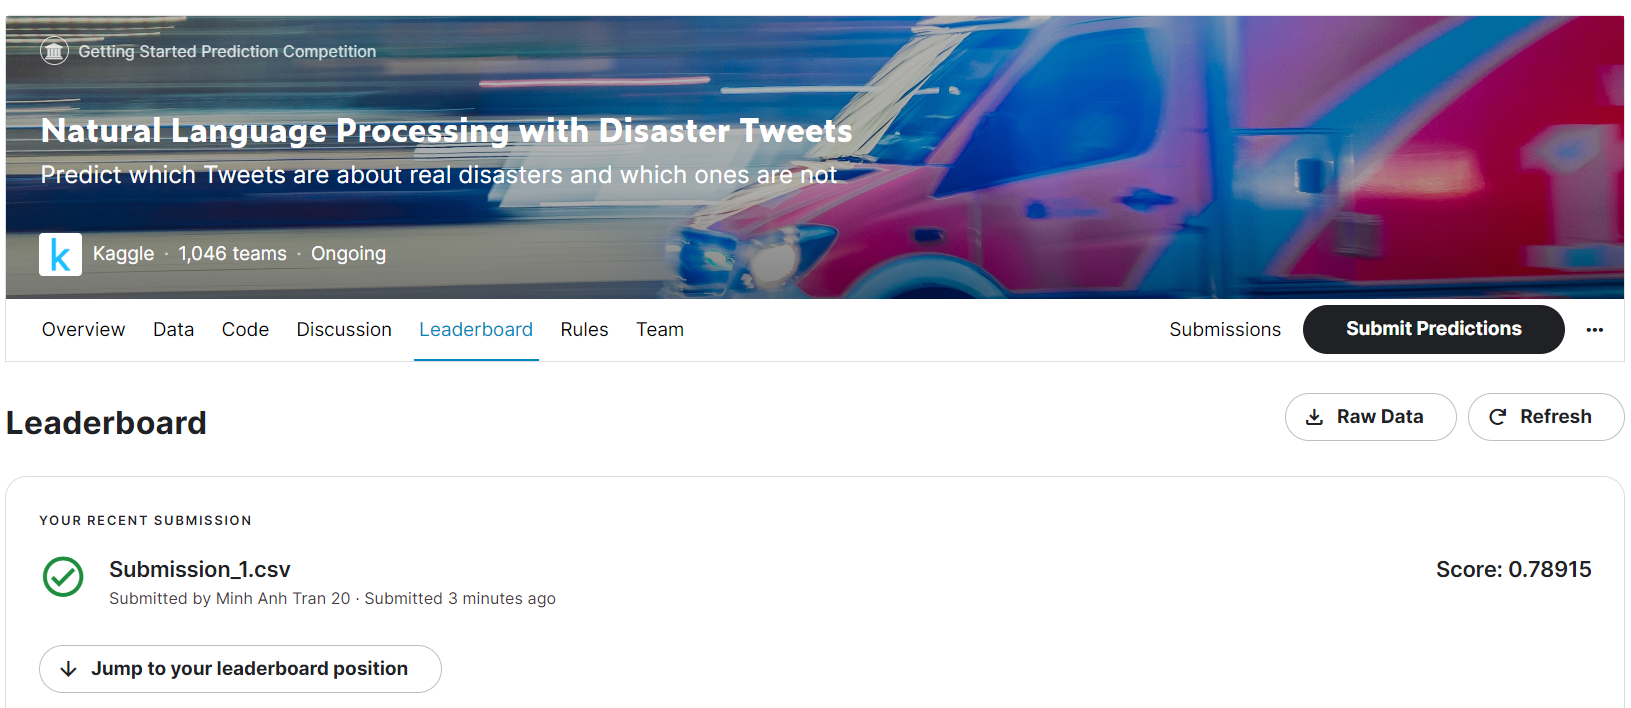